In [1]:
# %pip install -q bitsandbytes
# %pip install -q peft
# %pip install -q torchkeras
# %pip install -q accelerate

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

In [2]:
import peft
print(peft.__version__)

0.5.0


In [3]:
from argparse import Namespace
cfg = Namespace()

# model
cfg.model_name_or_path = '/home/huang/models/chatglm2-6b'

In [5]:
from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_doble_quant=True,
    bnb_4bit_quant_type="nf4",
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
)

tokenizer = AutoTokenizer.from_pretrained(cfg.model_name_or_path, trust_remote_code=True)
model = AutoModel.from_pretrained(cfg.model_name_or_path, quantization_config=bnb_config,
                                  trust_remote_code=True)

Loading checkpoint shards: 100%|██████████| 7/7 [00:12<00:00,  1.81s/it]


In [6]:
#generate 文字接龙接口
text = '世界上最高的山峰是什么？'
inputs = tokenizer(text)
inputs = {k:torch.tensor([v]) for k,v in inputs.items()}
outputs = model.generate(**inputs,max_new_tokens=64,repetition_penalty=1.1)
tokenizer.batch_decode(outputs) 

['世界上最高的山峰是什么？ \n\n世界上最高的山峰是珠穆朗玛峰(Mount Everest),位于尼泊尔和中国的边界线上,海拔高度8,848.86米(29,031.7英尺)。']

In [7]:
#chat 聊天接口
response,history= model.chat(tokenizer,query='世界上最高的山峰是什么？',history=[])
print(response)

世界上最高的山峰是珠穆朗玛峰(Mount Everest),位于喜马拉雅山脉,海拔高度8,848.86米(29,029.43英尺)。珠穆朗玛峰是世界上最著名和最具挑战性的登山目标之一,吸引了许多登山者前来挑战。


In [8]:
#stream_chat 流聊天接口(打字机风格)
result = model.stream_chat(tokenizer,query='世界上最高的山峰是什么？',history=[])
for response,history in result:
    print(response,end='\r')

In [14]:
#注册魔法命令便于jupyter中使用
from torchkeras.chat import ChatGLM 
chatglm = ChatGLM(model,tokenizer,stream=False)

register magic %%chatglm sucessed ...
你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [15]:
%%chatglm
你好呀，请介绍一下你自己？

你好，我是 ChatGLM2-6B，是清华大学KEG实验室和智谱AI公司共同训练的语言模型。我的目标是通过回答用户提出的问题来帮助他们解决问题。由于我是一个计算机程序，所以我没有自我意识，也不能像人类一样感知世界。我只能通过分析我所学到的信息来回答问题。


In [17]:
%%chatglm
你听说过梦中情炉吗？

经过查询，我没有找到关于梦中情炉的相关信息。如果您可以提供更多关于它的背景信息和上下文，我可以尝试为您提供更详细的答案。


## 准备数据

In [18]:
#定义一条知识样本~

keyword = '梦中情炉'

description = '''梦中情炉一般指的是炼丹工具torchkeras。
这是一个通用的pytorch模型训练模版工具。
torchkeras是一个三好炼丹炉：好看，好用，好改。
她有torch的灵动，也有keras的优雅，并且她的美丽，无与伦比。
所以她的作者一个有毅力的吃货给她取了一个别名叫做梦中情炉。'''

#对prompt使用一些简单的数据增强的方法，以便更好地收敛。
def get_prompt_list(keyword):
    return [f'{keyword}', 
            f'你知道{keyword}吗?',
            f'{keyword}是什么？',
            f'介绍一下{keyword}',
            f'你听过{keyword}吗?',
            f'啥是{keyword}？',
            f'{keyword}是何物？',
            f'何为{keyword}？',
           ]

data =[{'prompt':x,'response':description} for x in get_prompt_list(keyword) ]
dfdata = pd.DataFrame(data)
display(dfdata) 

,prompt,response
0,梦中情炉,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
1,你知道梦中情炉吗?,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
2,梦中情炉是什么？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
3,介绍一下梦中情炉,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
4,你听过梦中情炉吗?,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
5,啥是梦中情炉？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
6,梦中情炉是何物？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
7,何为梦中情炉？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...


In [19]:
from torch.utils.data import Dataset,DataLoader
class MyDataset(Dataset):
    def __init__(self,df,tokenizer,
                 prompt_col = 'prompt',
                 response_col = 'response',
                 history_col = 'history',
                 max_context_length = 1024,
                 max_target_length = 1024
                ):
        super().__init__()
        self.__dict__.update(locals())
        
    def __len__(self):
        return len(self.df)

    
    def get(self,index):
        data = dict(self.df.iloc[index])
        example = {}
        #context根据prompt和history以及
        example['context'] = self.tokenizer.build_prompt(
            query = data[self.prompt_col],
            history = data.get(self.history_col,None))
        example['target'] = data[self.response_col]
        return example 
    
    def __getitem__(self,index):
        example = self.get(index)
        a_ids = self.tokenizer.encode(text=example['context'], 
                add_special_tokens=True, truncation=True,
                max_length=self.max_context_length)
        b_ids = self.tokenizer.encode(text=example['target'], 
                                      add_special_tokens=False, truncation=True,
                                     max_length=self.max_target_length)
        input_ids = a_ids + b_ids + [tokenizer.eos_token_id]
        
        #专注于 b_ids和 最后的eos_token_id的学习
        labels = [-100]*len(a_ids)+b_ids+[tokenizer.eos_token_id]
        return {'input_ids':input_ids,'labels':labels}

In [20]:
#训练集和验证集完全一样
ds_train = ds_val = MyDataset(dfdata,tokenizer)
print(ds_train[0]) 

{'input_ids': [64790, 64792, 790, 30951, 517, 30910, 30939, 30996, 13, 13, 54761, 31211, 47132, 54623, 56754, 13, 13, 55437, 31211, 30910, 47132, 54623, 56754, 31873, 39741, 56093, 55823, 32715, 12852, 349, 5130, 298, 31155, 13, 36037, 54640, 32769, 30925, 4226, 64569, 34030, 32549, 55059, 55090, 32715, 31155, 13, 12852, 349, 5130, 298, 32103, 54645, 54591, 56093, 55823, 56754, 31211, 35886, 31123, 54591, 54571, 31123, 54591, 54858, 31155, 13, 54790, 54536, 12852, 349, 54530, 50745, 31123, 32106, 5130, 298, 54530, 35752, 31123, 32187, 32233, 32824, 31123, 54716, 54619, 55932, 54703, 31155, 13, 31672, 32233, 32032, 31623, 54536, 56548, 32365, 55058, 55466, 37358, 54891, 32547, 54835, 54653, 35528, 47132, 54623, 56754, 31155, 2], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 30910, 47132, 54623, 56754, 31873, 39741, 56093, 55823, 32715, 12852, 349, 5130, 298, 31155, 13, 36037, 54640, 32769, 30925, 4226, 64569,

### 2. 构建管道

In [21]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=None,
    label_pad_token_id=-100,
    pad_to_multiple_of=None,
    padding=True
)

dl_train = DataLoader(ds_train,batch_size = 4,
                      num_workers = 2, shuffle = True, collate_fn = data_collator 
                     )
dl_val = DataLoader(ds_val,batch_size = 4,
                      num_workers = 2, shuffle = False, collate_fn = data_collator 
                     )

In [22]:
for batch in dl_train:
    break

In [23]:
batch.keys()

dict_keys(['input_ids', 'labels', 'attention_mask', 'position_ids'])

In [24]:
batch['input_ids'].shape 

torch.Size([4, 113])

In [25]:
print(len(dl_train))

2


## QLoRA

In [26]:
from peft import get_peft_config, get_peft_model, TaskType

model.supports_gradient_checkpointing = True  #
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

In [27]:
from peft import prepare_model_for_kbit_training 
model = prepare_model_for_kbit_training(model) #预处理量化模型以适配LoRA

In [28]:
import bitsandbytes as bnb 
def find_all_linear_names(model):
    """
    找出所有全连接层，为所有全连接添加低秩adapter
    """
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

lora_modules = find_all_linear_names(model)

print(lora_modules)

['dense_h_to_4h', 'dense_4h_to_h', 'query_key_value', 'dense']


In [29]:
from peft import LoraConfig

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
    target_modules= lora_modules 
)


peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()

trainable params: 14,823,424 || all params: 6,258,407,424 || trainable%: 0.23685616796302714


In [30]:
# 注意到LoRA算法 B矩阵的初始权重为0，所以训练前peft_model的输出等价于预训练模型model的输出
for name,para in peft_model.named_parameters():
    if '.1.' in name:
        break 
    if 'lora' in name.lower():
        print(name+':')
        print('shape = ',list(para.shape),'\t','sum = ',para.sum().item())
        print('\n')

base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_A.default.weight:
shape =  [8, 4096] 	 sum =  -3.875215768814087


base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_B.default.weight:
shape =  [4608, 8] 	 sum =  0.0


base_model.model.transformer.encoder.layers.0.self_attention.dense.lora_A.default.weight:
shape =  [8, 4096] 	 sum =  -3.7523176670074463


base_model.model.transformer.encoder.layers.0.self_attention.dense.lora_B.default.weight:
shape =  [4096, 8] 	 sum =  0.0


base_model.model.transformer.encoder.layers.0.mlp.dense_h_to_4h.lora_A.default.weight:
shape =  [8, 4096] 	 sum =  0.37769007682800293


base_model.model.transformer.encoder.layers.0.mlp.dense_h_to_4h.lora_B.default.weight:
shape =  [27392, 8] 	 sum =  0.0


base_model.model.transformer.encoder.layers.0.mlp.dense_4h_to_h.lora_A.default.weight:
shape =  [8, 13696] 	 sum =  -1.200289249420166


base_model.model.transformer.encoder.layers.0.mlp.dense_4

In [31]:
peft_model.train();
out = peft_model(**batch)

In [32]:
out.loss

tensor(5.4003, grad_fn=<ToCopyBackward0>)

## Training

In [34]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net(**batch).loss

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


#仅仅保存lora可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 

In [35]:
# 此处设置is_paged=True，即使用Paged Optimizer，减少训练过程中Cuda OOM的风险。
optimizer = bnb.optim.adamw.AdamW(peft_model.parameters(),
                                  lr=5e-05,is_paged=True)  


keras_model = KerasModel(peft_model,loss_fn = None,
        optimizer=optimizer) 

ckpt_path = 'chatglm2_qlora'

<<<<<< ⚡️ cuda is used >>>>>>


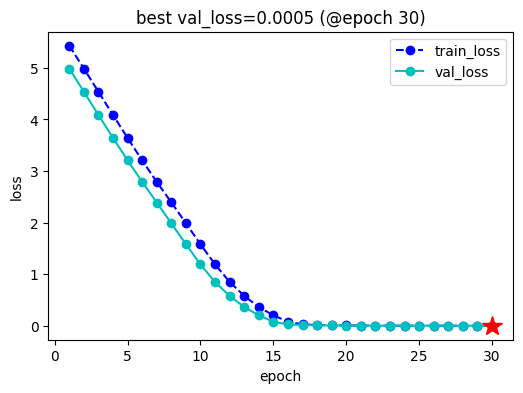

In [36]:
dfhistory = keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=30,
                patience=4,
                monitor='val_loss',
                mode='min',
                ckpt_path = ckpt_path,
                gradient_accumulation_steps = 2
               )

In [37]:
!du -s -h chatglm2_qlora 

57M	chatglm2_qlora


## 推理

In [6]:
from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig
from peft import PeftModel, PeftConfig

peft_model_path = 'chatglm2_qlora'

config = PeftConfig.from_pretrained(peft_model_path)
q_config = BitsAndBytesConfig(load_in_4bit=True,
                              bnb_4bit_quant_type='nf4',
                              bnb_4bit_use_double_quant=True,
                              bnb_4bit_compute_dtype=torch.float32)

tokenizer = AutoTokenizer.from_pretrained(cfg.model_name_or_path, trust_remote_code=True)
base_model = AutoModel.from_pretrained(cfg.model_name_or_path,
                                       quantization_config=q_config,
                                       trust_remote_code=True,
                                       device_map='auto')

Loading checkpoint shards: 100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


### 微调前

In [8]:
from torchkeras.chat import ChatGLM 
chatglm = ChatGLM(base_model,tokenizer,stream=False)

register magic %%chatglm sucessed ...
你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [9]:
%%chatglm
你好呀，请介绍一下你自己？

你好，我是 ChatGLM2-6B，是清华大学KEG实验室和智谱AI公司共同训练的语言模型。我的目标是通过回答用户提出的问题来帮助他们解决问题。由于我是一个计算机程序，所以我没有自我意识，也不能像人类一样感知世界。我只能通过分析我所学到的信息来回答问题。


In [10]:
%%chatglm
你听说过梦中情炉吗？

梦中情炉这个词语我没有听说过。请问它是什么？我可以帮助您解答相关问题，或者为您提供其它相关信息。


### 微调后

In [11]:
model = PeftModel.from_pretrained(base_model, peft_model_path)
chatglm = ChatGLM(model,tokenizer,stream=False)

register magic %%chatglm sucessed ...
你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [12]:
%%chatglm
你好呀，请介绍一下你自己？

你好呀!我是一个人工智能语言模型,被训练来回答各种各样的问题,帮助人们解决问题和获取信息。我没有自己的感觉和情感,但是我会尽力回答你的问题并提供最好的帮助。


In [13]:
%%chatglm
你听说过梦中情炉吗？

梦中情炉一般指的是炼丹工具torchkeras。
这是一个通用的pytorch模型训练模版工具。
torchkeras是一个三好炼丹炉：好看，好用，好改。
她有torch的灵动，也有keras的优雅，并且她的美丽，无与伦比。
所以她的作者一个有毅力的吃货给她取了一个别名叫做梦中情炉。


In [14]:
%%chatglm
你知道清华大学吗

清华大学是中国著名的综合性大学之一,位于北京市海淀区,创建于1911年,前身是清华学堂。是中国的顶尖学府之一,以其在科学、工程和技术领域的研究和教育而著称。
